# Feature engineering and selection

In [1]:
'''import sys
reload(sys)
sys.setdefaultencoding("utf-8")'''
import pandas as pd
import numpy as np

from collections import defaultdict
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import pickle
import time
from sklearn.ensemble import *
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#load the raw dataset

def load_data_set():
    train_data = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    test["outcome"] = 9
    bids = pd.read_csv('bids.csv')
    #bids = bids.sort(['auction', 'time'])
    return train_data,bids,test

train,bids,test = load_data_set()

In [9]:
'''
Alors fonction generer pour les bids l'ensemble des donnees suivantes : 
Pour chaque vente : temps moyen,max, std et min entre deux bids d une meme personne
                    temps moyen,max, st entre deux bids
                    nombre de bids max, min, et moyen de chaque utilisateur 
sauvegarde des resultats dans 3 csv differents
'''
def time_into_auction(train,bids,test):
    human = train[train.outcome==0].bidder_id
    bot = train[train.outcome==1].bidder_id
    grouped = bids.groupby('auction')
    done = -5
    #temps de bid par rapport aux dans une meme vente
    times_df = {}
    #temps de bid par rapport a soit meme pour chaque vente
    bid_himselft = {}
    #number of bids:
    number_bids = {}
    #wins auctions
    wins_auctions = {}
    moments_bids_final = {}
    remaining = len(grouped)
    difference=  [0,0]
    for bides in grouped:
        sub_data= bides[1]
        #sub_data.sort("time")
        last_bids = {}
        current_bids = {}
        start = 0
        end  = 0
        has_win = -1
        moments_bids = {}
        for acc in sub_data.iterrows():
            i,line = acc
            cle = line['bidder_id']
            if difference[0] == 0:
                difference[0] = line['time']
                start = line['time']
            else:
                if not cle in times_df:
                    times_df[cle] = []
                times_df[cle].append(line['time']-difference[0])
                difference[0] = line['time']
            if cle not in moments_bids:
                moments_bids[cle]= [line['time']]
            else:
                moments_bids[cle].append(line['time'])
            if cle not in last_bids:
                last_bids[cle] = (line['time'],[])
            else:
                last_bids[cle][1].append(line['time']-last_bids[cle][0])
                last_bids[cle] = (line['time'],last_bids[cle][1])
            if cle not in current_bids:
                current_bids[cle] = 1
            else:
                current_bids[cle] +=1
            end = line['time']
            has_win = cle
        #fusion des dictionnaires
        for c in current_bids:
            if not c in number_bids:
                number_bids[c] = [current_bids[c]]
            else:
                number_bids[c].append(current_bids[c])
        for c in last_bids:
            if not c in bid_himselft and len(last_bids[c][1])>0:
                bid_himselft[c] = last_bids[c]
            elif  len(last_bids[c][1])>0:
                bid_himselft[c] += last_bids[c]
        for c in moments_bids:
            if c not in moments_bids_final:
                moments_bids_final[c] = []
            moments_bids_final[c] += [((od-start)/float((end-start)+1.0)) for od in moments_bids[c]]
        loose = sub_data["bidder_id"].unique()
        for c in loose:
            if c not in wins_auctions:
                wins_auctions[c] = [0,0]
            wins_auctions[c][has_win==c] +=1
        if remaining %200 ==0:
            print("remaining : ", remaining)
        remaining -=1
    df = []
    for c in wins_auctions:
        wins_auctions[c] = wins_auctions[c][1] / float(np.sum(wins_auctions[c]))
    for cle in times_df.keys():
        df.append({'bidder_id': cle, 'mean_autres': np.mean(times_df[cle]),
    'min_autres': np.min(times_df[cle]), 'max_autres': np.max(times_df[cle]),'std_autres': np.std(times_df[cle])})
    pd.DataFrame(df).to_csv('res/time_auction.csv', index=False)
    df = []
    for cle in number_bids.keys():
        df.append({'bidder_id': cle, 'mean_number_bids': np.mean(number_bids[cle]),
    'min_number_bids': np.min(number_bids[cle]), 'max_number_bids': np.max(number_bids[cle]),
    'number_bids': len(number_bids[cle]),'std_number_bids': np.std(number_bids[cle])})
    pd.DataFrame(df).to_csv('res/bids_number.csv', index=False)
    df  = []
    for cle in bid_himselft.keys():
        val = bid_himselft[cle][1]
        df.append({'bidder_id': cle, 'mean_time_bids': np.mean(val),
    'min_time bids': np.min(val), 'max_time_bids': np.max(val),
    'number_of_auctions_bids': len(val),'std_time_bids': np.std(val)})
    pd.DataFrame(df).to_csv('res/himslef_time.csv', index=False)
    df  = []
    for cle in moments_bids_final.keys():
        #10 percent starting :
        #10 percent ending :
        starting = [(fre<0.1) for fre in moments_bids_final[cle]]
        ending = [(fre>0.9) for fre in moments_bids_final[cle]]
        #print(moments_bids_final[cle][moments_bids_final[cle]>0.10])
        df.append({'bidder_id': cle, 'average_moment_bid': np.mean(moments_bids_final[cle]),
    'std_moment_bid':np.std(moments_bids_final[cle]),'frequence_wind':wins_auctions[cle], 'starting_quick' : float(np.sum(starting))/float(len(starting)),
        'ending_quick' : float(np.sum(ending))/float(len(ending))})
    pd.DataFrame(df).to_csv('res/other_stats.csv', index=False)
    

recreate_feature = False
if recreate_feature:
    time_into_auction(train,bids,test)

In [4]:
import pickle
import os.path

#genere de nouvelles features relatives aux ips, pays et nombre de bids
def normalize(dicts):
    for c in dicts:
        tmp = dicts[c]
        total = float(np.sum(tmp))
        dicts[c] = (tmp[0]/total,tmp[1]/total)
    return dicts
# generate the features using the features created before
def feature_creation(train,test,bids):
    #number of differents ips,urls
    grouped = bids.groupby(['bidder_id','auction'])
    app_mean = grouped.device.nunique().groupby(level=0).mean()
    app_std = grouped.device.nunique().groupby(level=0).count()
    app_max = grouped.device.nunique().groupby(level=0).max()
    ip_mean = grouped.ip.nunique().groupby(level=0).mean()
    ip_std = grouped.ip.nunique().groupby(level=0).count()
    ip_max = grouped.ip.nunique().groupby(level=0).max()
    pays_mean = grouped.country.nunique().groupby(level=0).mean()
    pays_std = grouped.country.nunique().groupby(level=0).count()
    pays_max = grouped.country.nunique().groupby(level=0).max()
    page_mean = grouped.url.nunique().groupby(level=0).mean()
    page_std = grouped.url.nunique().groupby(level=0).count()
    page_max = grouped.url.nunique().groupby(level=0).max()
    df = []
    for cle in app_mean.keys():
        df.append({'bidder_id' : cle, 'app_mean': app_mean[cle], 'app_std': app_std[cle],
    'app_max': app_max[cle], 'ip_mean': ip_mean[cle],
    'ip_std': ip_std[cle],'ip_max': ip_max[cle],'pays_mean': pays_mean[cle],'pays_std': pays_std[cle],'pays_max': pays_max[cle],
    'page_mean': page_mean[cle],'page_std': page_std[cle],'page_max': page_max[cle]})
    pd.DataFrame(df).to_csv('res/nb_uniques.csv', index=False)
    df = []
    human = train[train.outcome==0]
    bots = train[train.outcome==1]
    human_bids = bids[bids["bidder_id"].isin(human["bidder_id"])]
    robot_bids = bids[bids["bidder_id"].isin(bots["bidder_id"])]
    show_stats = False
    if show_stats:
        import matplotlib.pyplot as plt
        import seaborn as sn
        %matplotlib inline
        countries = bids["country"].unique()
        for c in countries:
            sub_d_h= human_bids[human_bids["country"] == c]
            sub_d_r= robot_bids[robot_bids["country"] == c]
            if len(sub_d_r)>1:
                tmp_plot = sub_d_h.groupby("time").count()
                tmp_plot2 = sub_d_r.groupby("time").count()
                plt.plot(tmp_plot.index,tmp_plot,label="human",alpha=0.7)
                plt.plot(tmp_plot2.index,tmp_plot2,label="robot",alpha=0.7)
                plt.legend()
                plt.show()
    #average moment of biding in the auction and win percentage
    countries = {}
    urls = {}
    devices = {}
    ips = {}
    auctions = {}
    merchandises = {}
    times = {}
    if os.path.exists("stats/urls.pkl"):
        with open('stats/urls.pkl', 'rb') as handle:
            urls = pickle.load(handle)
        with open('stats/countries.pkl', 'rb') as handle:
            countries = pickle.load(handle)
        with open('stats/devices.pkl', 'rb') as handle:
            devices = pickle.load(handle)
        with open('stats/merchandises.pkl', 'rb') as handle:
            merchandises = pickle.load(handle)
        with open('stats/auctions.pkl', 'rb') as handle:
            auctions = pickle.load(handle)
        with open('stats/times.pkl', 'rb') as handle:
            times = pickle.load(handle)
        print(len(auctions),len(times),len(merchandises),len(devices),len(countries),len(urls))
    else:
        to_do = len(bids)
        bots_values = bots["bidder_id"].values
        #basics stats
        for i,acc in bids.iterrows():
            url = acc["url"]
            country = acc["country"]
            device = acc["device"]
            bid = acc["auction"]
            merchan = acc["merchandise"]
            time = acc["time"]
            cle = acc["bidder_id"]
            bot = cle in bots_values
            if url not in urls:
                urls[url] = [0,0]
            if country not in countries:
                countries[country] = [0,0]
            if device not in devices:
                devices[device] = [0,0]
            if bid not in auctions:
                auctions[bid] = [0,0]
            if merchan not in merchandises:
                merchandises[merchan] = [0,0]
            if time not in times:
                times[time] = [0,0]
            if bot:
                urls[url][0] +=1
                countries[country][0] +=1
                devices[device][0] +=1
                merchandises[merchan][0] +=1
                auctions[bid][0] +=1
                times[time][0] +=1
            else:
                urls[url][1] +=1
                countries[country][1] +=1
                devices[device][1] +=1
                merchandises[merchan][1] +=1
                auctions[bid][1] +=1
                times[time][1] +=1 
            to_do -= 1
            if to_do % 100000 ==0:
                print(to_do)
        urls = normalize(urls)
        countries = normalize(countries)
        devices = normalize(devices)
        merchandises = normalize(merchandises)
        auctions = normalize(auctions)
        times = normalize(times)
        with open('stats/urls.pkl', 'wb') as handle:
            pickle.dump(urls, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('stats/countries.pkl', 'wb') as handle:
            pickle.dump(countries, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('stats/devices.pkl', 'wb') as handle:
            pickle.dump(devices, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('stats/merchandises.pkl', 'wb') as handle:
            pickle.dump(merchandises, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('stats/auctions.pkl', 'wb') as handle:
            pickle.dump(auctions, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('stats/times.pkl', 'wb') as handle:
            pickle.dump(times, handle, protocol=pickle.HIGHEST_PROTOCOL)
    grouped_person = bids.groupby(['bidder_id'])
    url_score = {}
    country_score = {}
    merchan_score = {}
    devices_score = {}
    auct_score = {}
    times_score = {}
    remaining = len(grouped_person)
    print("TO DO : ",remaining)
    bots_values = bots["bidder_id"].values
    for bides in grouped_person:
        sub_data= bides[1]
        for i,acc in sub_data.iterrows():
            cle = acc["bidder_id"]
            bot = cle in bots_values
            if cle not in url_score:
                url_score[cle] = urls[acc["url"]][int(bot)]
            if cle not in country_score:
                cle_c = acc["country"]
                if acc["country"] != "nan":
                    cle_c = "in"
                country_score[cle] = countries[cle_c][int(bot)]
            if cle not in merchan_score:
                merchan_score[cle] = merchandises[acc["merchandise"]][int(bot)]
            if cle not in devices_score:
                devices_score[cle] = devices[acc["device"]][int(bot)]
            if cle not in auct_score:
                auct_score[cle] = auctions[acc["auction"]][int(bot)]
            if cle not in times_score:
                times_score[cle] = times[acc["time"]][int(bot)]
        url_score[cle] = url_score[cle]  /float(len(sub_data))
        country_score[cle] = country_score[cle]  /float(len(sub_data))
        devices_score[cle] = devices_score[cle]  /float(len(sub_data))
        merchan_score[cle] = merchan_score[cle]  /float(len(sub_data))
        auct_score[cle] = auct_score[cle]  /float(len(sub_data))
        times_score[cle] = times_score[cle]  /float(len(sub_data))
        if remaining % 500 ==0:
            print(remaining)
        remaining -=1
    df  = []
    for cle in url_score.keys():
        df.append({'bidder_id' : cle, 'url_score': url_score[cle], 'country_score': country_score[cle],
    'device_score': devices_score[cle], 'merchan_score': merchan_score[cle],
    'zauc_score': auct_score[cle],'time_score': times_score[cle]})
    pd.DataFrame(df).to_csv('res/scores.csv', index=False)
    
    #to do : total number of bids, max nombre de bids dans une fentre de 15 minutes
    #nombre de bids pour chacun des jours
    '''
    heure moyen de bid
    number of simulatneous bids
    est ce que c'est une heire normale (calculer pour chaque pays fenetre la plus utilisee dans la journee)
    appartenir a url ? 'vasstdc27m7nks3(proba)
    '''
recreate = False
if recreate:
    feature_creation(train,test,bids)

In [76]:
# Generate new features :
from collections import Counter
def new_features(train,test,bids):
    countries= bids.country.unique()
    countries_nb = {}
    for c in countries:
        countries_nb[c] = bids[bids["country"] == c].bidder_id.value_counts()
    #consecutive bids
    tmp = bids.groupby(["bidder_id"]).time
    max_four = {}
    max_five= {}
    max_six = {}
    remaining = len(tmp)
    consevuctive_bids_mean = {}
    consevuctive_bids_min = {}
    consevuctive_bids_std = {}
    for d in tmp:
        cle = d[0]
        sub_data= d[1]
        sub_data.sort()
        four = np.max(Counter([str(nb)[:4] for nb in sub_data]).values())
        five = np.max(Counter([str(nb)[:5] for nb in sub_data]).values())
        six = np.max(Counter([str(nb)[:6] for nb in sub_data]).values())
        diff = np.ediff1d(sub_data)
        if len(diff)>0:
            consevuctive_bids_mean[cle] = np.mean(diff)
            consevuctive_bids_min[cle] = np.min(diff)
            consevuctive_bids_std[cle]= np.std(diff)
        max_four[cle] = four
        max_five[cle] = five
        max_six[cle] = six
        if remaining % 1000 ==0:
            print(remaining)
        remaining -=1
    ips_india_user = bids[(bids["country"] == "in")].groupby(["bidder_id"]).ip.nunique()
    ips_per_user = (bids.groupby(["bidder_id"]).ip.nunique())
    unique_time_user = (bids.groupby(["bidder_id"]).time.nunique())
    device_per_user = (bids.groupby(["bidder_id"]).device.nunique())
    url_per_user = (bids.groupby(["bidder_id"]).url.nunique())
    total_auction = bids.groupby("bidder_id").auction.count()
    total_bids = bids["bidder_id"].value_counts()
    #bid in each country
    merchandises = bids.merchandise.unique()
    merchan_nb = {}
    for m in merchandises:
        merchan_nb[m] = bids[bids["merchandise"] == m].bidder_id.value_counts()
    df = []
    for c in total_bids.keys():
        tmp = {'bidder_id' : c,  "ips_per_user" : ips_per_user[c], "device_user" : device_per_user[c],
                  "unq_time_user" : unique_time_user[c], "url_user" : url_per_user[c]}
        if c in ips_india_user:
            tmp["ips_india"] = ips_india_user[c]
        else:
            tmp["ips_india"] = 0
        if c in total_auction:
            tmp["total_ac"] = total_auction[c]
        else:
            tmp["total_ac"] = 0
        if c in total_bids:
            tmp["total_bids"] = total_bids[c]
        else:
            tmp["total_bids"] = 0
        for count in countries:
            if c in countries_nb[count]:
                tmp[str(count)] = countries_nb[count][c]
            else:
                tmp[str(count)] = 0
        for count in merchan_nb.keys():
            if c in merchan_nb[count]:
                tmp[str(count)] = merchan_nb[count][c]
            else:
                tmp[str(count)] = 0
        if c in consevuctive_bids_mean:
            tmp["consec_bids_mean"] = consevuctive_bids_mean[c]
            tmp["consec_bids_min"] = consevuctive_bids_min[c]
            tmp["consec_bids_std"] = consevuctive_bids_std[c]
        if c in max_four:
            tmp["max_four"] = max_four[c]
            tmp["max_five"] = max_five[c]
            tmp["max_six"] = max_six[c]
        df.append(tmp)
    pd.DataFrame(df).to_csv('res/newss_stats.csv', index=False)        

#new_features(train,test,bids)

In [3]:
#charge les fichiers contenant les features et fait une jointure sur l id des bidders
#on sauvegarde le train set et le test set dans un fichier csv
def load_all(train,test,bids):
    bids_numbers = pd.read_csv('res/bids_number.csv')
    himself_time = pd.read_csv('res/himslef_time.csv')
    other = pd.read_csv('res/other_stats.csv')
    scores = pd.read_csv('res/scores.csv')
    time_auction = pd.read_csv('res/time_auction.csv')
    nb_uniques = pd.read_csv('res/nb_uniques.csv')
    new_feats = pd.read_csv("res/newss_stats.csv")
    #test file
    y_train = train["outcome"]
    #new train representation
    new_train = train["bidder_id"].to_frame()
    new_train = pd.merge(new_train,bids_numbers,on="bidder_id",how="left")
    new_train = pd.merge(new_train,himself_time,on="bidder_id",how="left")
    new_train = pd.merge(new_train,other,on="bidder_id",how="left")
    new_train = pd.merge(new_train,scores,on="bidder_id",how="left")
    new_train = pd.merge(new_train,time_auction,on="bidder_id",how="left")
    new_train = pd.merge(new_train,nb_uniques,on="bidder_id",how="left")
    new_train = pd.merge(new_train,new_feats,on="bidder_id",how="left")
    new_train= new_train.fillna(new_train.mean())
    #new test
    new_test = test["bidder_id"].to_frame()
    new_test = pd.merge(new_test,bids_numbers,on="bidder_id",how="left")
    new_test = pd.merge(new_test,himself_time,on="bidder_id",how="left")
    new_test = pd.merge(new_test,other,on="bidder_id",how="left")
    new_test = pd.merge(new_test,scores,on="bidder_id",how="left")
    new_test = pd.merge(new_test,time_auction,on="bidder_id",how="left")
    new_test = pd.merge(new_test,nb_uniques,on="bidder_id",how="left")
    new_test = pd.merge(new_test,new_feats,on="bidder_id",how="left")
    new_test= new_test.fillna(new_test.mean())
    #new_train = new_train.drop("max_number_bids",axis=1)
    #new_test = new_test.drop("max_number_bids",axis=1)
    new_train = new_train.drop(["time_score","url_score","merchan_score","zauc_score","device_score","country_score"],axis=1)
    new_test = new_test.drop(["time_score","url_score","merchan_score","zauc_score","device_score","country_score"],axis=1)
    to_drop = ["pays_max","min_number_bids","pays_max"]
    new_train = new_train.drop(to_drop,axis=1)
    new_test = new_test.drop(to_drop,axis=1)
    return new_train,new_test,y_train

def test_loading(train,test,bids):
    time_auction = pd.read_csv('res/time_auction.csv')
    auctions_stats = pd.read_csv('res/stats_test.csv')
    auctions_stats_simple = pd.read_csv("res/stats_test_simple.csv")
    auctions_stats = auctions_stats.groupby('bidder_id',as_index=False).mean()
    '''print(auctions_stats.bidder_id)
    print(auctions_stats_simple.bidder_id)
    auctions_stats.rename(columns=lambda x: x+str("_c"), inplace=True)
    auctions_stats.rename(columns={"bidder_id_c":"bidder_id"},inplace=True)'''
    auctions_stats = pd.merge(auctions_stats,time_auction,on="bidder_id")
    auctions_stats_simple = pd.merge(auctions_stats_simple,auctions_stats,on="bidder_id")
    new_train = train[["bidder_id","outcome"]].copy()
    #y_train = train["outcome"]
    new_test = test[["bidder_id"]].copy()
    new_train = pd.merge(new_train,auctions_stats_simple,on="bidder_id")
    y_train = new_train["outcome"]
    #new_train = new_train.drop("outcome",axis=1)
    new_test = pd.merge(new_test,auctions_stats_simple,on="bidder_id")
    #new_test= new_test.fillna(mean_s)
    #new_train= new_train.fillna(mean_s)
    return new_train,new_test,y_train

X_train,X_test,y_train = test_loading(train,test,bids)
print(X_test.bidder_id.unique().shape)
print(X_train.bidder_id.unique().shape)
#X_trXain,X_test,y_train = load_all(train,test,bids)

(4630,)
(1984,)


In [5]:
X_train.to_csv("debug_train.csv",index=False)
X_test.to_csv("debug_test.csv",index=False)

In [4]:
train = pd.read_csv("debug_train.csv")
train['outcome'] = train['outcome'].astype(int)
ytrain = train['outcome']
train.drop('outcome', 1, inplace=True)
train.drop(labels=['bidder_id'], axis=1, inplace=True)
test = pd.read_csv("debug_test.csv")

# Grid search :

Gradient boosting classifier : 

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
def grid_seach(train,ytrain):
    model = GradientBoostingClassifier(max_features=50,random_state=9)
    parameters = {'n_estimators':[50,100,200,300], 'max_depth':[3,5,7,9],'learning_rate':[0.01,0.03,0.05,0.1]}
    clf = GridSearchCV(model, parameters,cv=10,n_jobs=-1,scoring='roc_auc')
    clf.fit(train, y_train)
    print(clf.best_score_)
    print(clf.best_params_)
    with open('mode_res_GradientBoostingClassifier.pickle', 'wb') as handle:
        pickle.dump(clf.grid_scores_, handle, protocol=pickle.HIGHEST_PROTOCOL)
grid_seach(train,ytrain)

0.926312387539
{'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 9}


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


AdaBoostClassifier :

In [14]:
from sklearn.ensemble import AdaBoostClassifier
def grid_seach(train,ytrain):
    model = AdaBoostClassifier(random_state=9)
    parameters = {'n_estimators':[50,100,200,300],'learning_rate':[0.01,0.03,0.05,0.1,0.3,0.7,1.0,1.5,2.0]}
    clf = GridSearchCV(model, parameters,cv=10,n_jobs=-1,scoring='roc_auc')
    clf.fit(train, y_train)
    print(clf.best_score_)
    print(clf.best_params_)
    with open('mode_res_AdaBoostClassifier.pickle', 'wb') as handle:
        pickle.dump(clf.grid_scores_, handle, protocol=pickle.HIGHEST_PROTOCOL)
grid_seach(train,ytrain)

0.922930538219
{'n_estimators': 200, 'learning_rate': 0.03}


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


KNN : 

In [16]:
from sklearn.neighbors import KNeighborsClassifier
def grid_seach(train,ytrain):
    model = KNeighborsClassifier(n_jobs=-1) 
    parameters = {'n_neighbors':[1,3,5,10],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}
    clf = GridSearchCV(model, parameters,cv=10,n_jobs=-1,scoring='roc_auc')
    clf.fit(train, y_train)
    print(clf.best_score_)
    print(clf.best_params_)
grid_seach(train,ytrain)

/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


0.781051604324
{'n_neighbors': 10, 'algorithm': 'auto'}


Xgboost : 

In [25]:
import xgboost
from sklearn.ensemble import AdaBoostClassifier
def grid_seach(train,ytrain):
    model = xgboost.XGBClassifier()
    parameters = {'max_depth': [3,6,10],  "n_estimators" : [50,100]}#,"gamma" : np.logspace(-3,0,10)}
    clf = GridSearchCV(model, parameters,cv=10,n_jobs=-1,scoring='roc_auc',verbose=2)
    clf.fit(train, y_train)
    print(clf.best_score_)
    print(clf.best_params_)
    with open('mode_res_XGBClassifier.pickle', 'wb') as handle:
        pickle.dump(clf.grid_scores_, handle, protocol=pickle.HIGHEST_PROTOCOL)
grid_seach(train,ytrain)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] n_estimators=50, max_depth=3 ....................................
[CV] n_estimators=50, max_depth=3 ....................................
[CV] n_estimators=50, max_depth=3 ....................................
[CV] n_estimators=50, max_depth=3 ....................................
[CV] ........................... n_estimators=50, max_depth=3 -   0.2s
[CV] n_estimators=50, max_depth=3 ....................................
[CV] ........................... n_estimators=50, max_depth=3 -   0.2s
[CV] n_estimators=50, max_depth=3 ....................................
[CV] ........................... n_estimators=50, max_depth=3 -   0.1s
[CV] n_estimators=50, max_depth=3 ....................................
[CV] ........................... n_estimators=50, max_depth=3 -   0.1s
[CV] n_estimators=50, max_depth=3 ....................................
[CV] ........................... n_estimators=50, max_depth=3 -   0.2s
[CV] n_estimator

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.6min


[CV] .......................... n_estimators=100, max_depth=6 -   0.1s
[CV] n_estimators=100, max_depth=6 ...................................
[CV] .......................... n_estimators=100, max_depth=6 -   0.1s
[CV] n_estimators=100, max_depth=6 ...................................
[CV] .......................... n_estimators=100, max_depth=6 -   0.2s
[CV] n_estimators=100, max_depth=6 ...................................
[CV] .......................... n_estimators=100, max_depth=6 -   0.2s
[CV] n_estimators=50, max_depth=10 ...................................
[CV] .......................... n_estimators=100, max_depth=6 -   0.2s
[CV] n_estimators=50, max_depth=10 ...................................
[CV] .......................... n_estimators=100, max_depth=6 -   0.1s
[CV] n_estimators=50, max_depth=10 ...................................
[CV] .......................... n_estimators=100, max_depth=6 -   0.2s
[CV] n_estimators=50, max_depth=10 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 26.5min finished


0.920764204344
{'n_estimators': 50, 'max_depth': 6}


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [189]:
# first ml algo
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV


def to_kaggle(X_train,X_test,y_train):
    test_ids = X_test['bidder_id']
    X_test = X_test.drop(labels=['bidder_id'], axis=1, inplace=False)
    predictions = predict(X_train, X_test, y_train)
    sub = pd.read_csv('sampleSubmission.csv')
    result = pd.DataFrame()
    result['bidder_id'] = test_ids
    result['outcome'] = predictions
    sub = sub.merge(result, on='bidder_id', how='left')
    # Fill missing values with mean
    sub.fillna(0.0511674, inplace=True)
    sub.drop('prediction', 1, inplace=True)
    sub.to_csv('submission/random.csv', index=False, header=['bidder_id', 'prediction'])

def predict(X_train, X_test, y_train,clf=RandomForestClassifier(n_estimators=250,max_depth=8, max_features = 45 , random_state=9,criterion='entropy'),mode='soft'):
    clf.fit(X_train, y_train)
    if mode=="soft":
        predictions = clf.predict_proba(X_test)[:, 1]
    elif mode=="hard":
        print("Predict Class")
        predictions = clf.predict(X_test)
    return predictions

def predict_model(X_train, X_test, y_train,model):
    model.fit(X_train, y_train)
    predictions = model.predict_proba(X_test)[:, 1]
    return predictions

def cross_val_score(train,ytrain):
    kf = StratifiedKFold(y=ytrain, n_folds=10)
    scores = []
    for train_index, test_index in kf:
        X_train, X_test = train.iloc[train_index], train.iloc[test_index]
        y_train, y_test = ytrain.iloc[train_index], ytrain.iloc[test_index]
        predictions = predict(X_train, X_test, y_train)
        scores.append(roc_auc_score(y_test, predictions))
    print np.mean(scores)
def grid_seach(train,ytrain):
    model = RandomForestClassifier(max_depth=8,random_state=9,criterion='entropy') 
    parameters = {'n_estimators':[50,100,150,200,250,300], 'max_features':[6,8,10,20,25,30,25,40,45,50,60,70,80]}
    clf = GridSearchCV(model, parameters,cv=10,n_jobs=-1,scoring='roc_auc')
    clf.fit(train, y_train)
    print(clf.best_score_)
    print(clf.best_params_)
    with open('mode_res.pickle', 'wb') as handle:
        pickle.dump(clf.grid_scores_, handle, protocol=pickle.HIGHEST_PROTOCOL)

def test_models(train,ytrain):
    kf = StratifiedKFold(y=ytrain, n_folds=10)
    models = [RandomForestClassifier(n_estimators=160,max_depth=8, max_features = 35 , random_state=9,criterion='entropy'),AdaBoostClassifier(),
             GradientBoostingClassifier(),KNeighborsClassifier(),AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=200,max_depth=8, max_features = 35 , random_state=9,criterion='entropy')),
             SVC(kernel="poly",probability=True),SVC(probability=True),DecisionTreeClassifier()]
    res_per_models = {}
    for m in models:
        print("-------------------------")
        print(str(m))
        start = time.time()
        scores = []
        for train_index, test_index in kf:
            X_train, X_test = train.iloc[train_index], train.iloc[test_index]
            y_train, y_test = ytrain.iloc[train_index], ytrain.iloc[test_index]
            predictions = predict_model(X_train, X_test, y_train,m)
            scores.append(roc_auc_score(y_test, predictions))
        print np.mean(scores)
        end = time.time()
        res_per_models[str(m)] = (np.mean(scores),end)
    with open('multi_modles.pickle', 'wb') as handle:
        pickle.dump(res_per_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

def train_size_impact(train,ytrain):
    m1 = RandomForestClassifier(n_estimators=250,max_depth=8, max_features = 45 , random_state=9,criterion='entropy')
    m5 = RandomForestClassifier(n_estimators=300,max_depth=8, max_features = 30 , random_state=81,criterion='entropy')
    m2 = AdaBoostClassifier(n_estimators=200,learning_rate=0.03,random_state=9)
    m3 = GradientBoostingClassifier(max_features=50,random_state=9,n_estimators=200,learning_rate=0.1,max_depth=9)
    m4 = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=200,max_depth=8, max_features = 35 , random_state=9,criterion='entropy'))
    models = [('rfc' , m1) ,('adCL' , m2) , ("gdC" , m3), ("adaRFC" , m4) , ("rfc2",m5)]
    model = VotingClassifier(estimators=models,voting="soft",n_jobs=-1)
    res_per_models = []
    taille = np.linspace(0.15,1,15)
    for t in taille:
        print("-------------------------")
        start = time.time()
        scores = []
        X_tmp = train.copy()
        X_tmp["ppppp"] = ytrain
        X_tmp = X_tmp.sample(n=int(len(ytrain)*t))
        y_tmp = X_tmp["ppppp"]
        X_tmp = X_tmp.drop("ppppp",axis=1)
        kf = StratifiedKFold(y=y_tmp, n_folds=10)
        for train_index, test_index in kf:
            X_train, X_test = X_tmp.iloc[train_index], X_tmp.iloc[test_index]
            y_train, y_test = y_tmp.iloc[train_index], y_tmp.iloc[test_index]
            predictions = predict_model(X_train, X_test, y_train,model)
            scores.append(roc_auc_score(y_test, predictions))
        print np.mean(scores)
        res_per_models.append(np.mean(scores))
    with open('modele_percent.pickle', 'wb') as handle:
        pickle.dump(res_per_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
def mean_predict(X_train, X_test, y_train,models):
    total_predict = []
    for name,model in models:
        total_predict.append(predict(X_train, X_test, y_train,clf=model,mode='soft'))
    predictions = np.mean(total_predict,axis=0)
    return predictions
def special_hard(predictions):
    predictions_rounded = []
    for tab in predictions:
        predictions_rounded.append([(int((round(tab[i],2)*20))/20.0) for i in range(len(tab))])
    predictions_rounded = np.array(predictions_rounded)
    freq_test = []
    for i in range(len(predictions_rounded[0])):
        freq_test.append(itemfreq(predictions_rounded[:,i]))
    final_pred = []
    for i in range(len(freq_test)):
        if len(freq_test[i])==5:
            final_pred.append(np.mean(freq_test[i][:,0]))
        else:
            final_pred.append(freq_test[i][np.argmax(freq_test[i][:,1])][0])
    return final_pred
def voting_classifier_model(train,ytrain,hard= 'soft'):
    m1 = RandomForestClassifier(n_estimators=250,max_depth=8, max_features = 45 , random_state=9,criterion='entropy')
    m5 = RandomForestClassifier(n_estimators=300,max_depth=8, max_features = 30 , random_state=81,criterion='entropy')
    m2 = AdaBoostClassifier(n_estimators=200,learning_rate=0.03,random_state=9)
    m3 = GradientBoostingClassifier(max_features=50,random_state=9,n_estimators=200,learning_rate=0.1,max_depth=9)
    m4 = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=200,max_depth=8, max_features = 35 , random_state=9,criterion='entropy'))
    models = [('rfc' , m1) ,('adCL' , m2) , ("gdC" , m3), ("adaRFC" , m4) , ("rfc2",m5)]
    if hard != 'mean':
        eclf1 = VotingClassifier(estimators=models,voting=hard,n_jobs=-1)
    kf = StratifiedKFold(y=ytrain, n_folds=10)
    scores = []
    n_folds = 0
    for train_index, test_index in kf:
        print("Fold number : " , n_folds)
        n_folds +=1
        X_train, X_test = train.iloc[train_index], train.iloc[test_index]
        y_train, y_test = ytrain.iloc[train_index], ytrain.iloc[test_index]
        if hard == "soft":
            predictions = predict(X_train, X_test, y_train,clf=eclf1,mode=hard)
        elif hard=="hard":
            total_pred = []
            for name,mo in models:
                total_pred.append(predict(X_train, X_test, y_train,clf=mo))
            predictions = special_hard(total_pred)
        else:
            predictions = mean_predict(X_train, X_test, y_train,models)
            '''total_predict = []
            for name,model in models:
                total_predict.append(predict(X_train, X_test, y_train,clf=model,mode='soft'))
            predictions = np.mean(total_predict,axis=0)'''
        scores.append(roc_auc_score(y_test, predictions))
    print np.mean(scores)
'''"
kf = StratifiedKFold(y=ytrain, n_folds=10)
scores = []
for train_index, test_index in kf:
    X_train, X_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = ytrain.iloc[train_index], ytrain.iloc[test_index]
    predictions = predict(X_train, X_test, y_train)
    scores.append(roc_auc_score(y_test, predictions))
print np.mean(scores)'''
#grid_seach(train,ytrain)
#to_kaggle(train,test,ytrain)
#test_models(train,ytrain)
#train_size_impact(train,ytrain)
'''print("soft  : ")
voting_classifier_model(train,ytrain,hard="soft")
print("hard  : ")
voting_classifier_model(train,ytrain,hard="hard")
print("mean  : ")
voting_classifier_model(train,ytrain,hard="mean")'''
train_size_impact(train,ytrain)
#voting_classifier_model(train,ytrain,hard="hard")
'''
soft  : 
0.932371485882
hard  : 
Predict Class
Predict Class
Predict Class
Predict Class
Predict Class
Predict Class
Predict Class
Predict Class
Predict Class
Predict Class
0.918004155025
mean  : 
0.93256974507
'''

-------------------------
0.971428571429
-------------------------
0.864615384615
-------------------------
0.930345022624
-------------------------
0.921594982079
-------------------------
0.936598173516
-------------------------
0.924743697479
-------------------------
0.928971219931
-------------------------
0.941053346925
-------------------------
0.928996265173
-------------------------
0.923162651598
-------------------------


Process PoolWorker-506:
Process PoolWorker-505:
Process PoolWorker-507:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap


KeyboardInterrupt: 

In [16]:
from sklearn.model_selection import cross_val_predict
clf = RandomForestClassifier(n_estimators=160,max_depth=8, max_features = 35 , random_state=9,criterion='entropy')
y_pred = cross_val_predict(clf, train, ytrain,method='predict_proba')[:, 1]

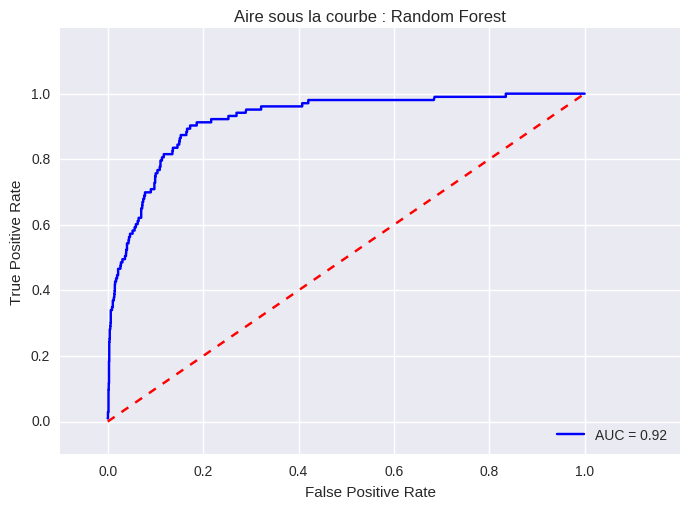

In [19]:
#affiche l'aire sous la courbe pour un random forest classifier
from sklearn.metrics import roc_curve, auc
import seaborn as sn
import matplotlib.pyplot as plt
false_positive_rate, true_positive_rate, thresholds = roc_curve(ytrain, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Aire sous la courbe : Random Forest')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# For different models :

In [114]:
from sklearn.model_selection import cross_val_predict
models_bis = [RandomForestClassifier(),
AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=100, max_features = 35 , random_state=9,criterion='entropy')),
SVC(kernel="poly",probability=True),DecisionTreeClassifier()]

predictions = []
print("debut learning : " , len(models_bis))
for mo in models_bis:
    pred = cross_val_predict(mo, train, ytrain,method='predict_proba')[:, 1]
    predictions.append(pred)



('debut learning : ', 4)


In [ ]:
print("ok")

In [140]:
m1 = RandomForestClassifier(n_estimators=250,max_depth=8, max_features = 45 , random_state=9,criterion='entropy')
m5 = RandomForestClassifier(n_estimators=300,max_depth=8, max_features = 30 , random_state=81,criterion='entropy')
m2 = AdaBoostClassifier(n_estimators=200,learning_rate=0.03,random_state=9)
m3 = GradientBoostingClassifier(max_features=50,random_state=9,n_estimators=200,learning_rate=0.1,max_depth=9)
m4 = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=200,max_depth=8, max_features = 35 , random_state=9,criterion='entropy'))
models = [('rfc' , m1) ,('adCL' , m2) , ("gdC" , m3), ("adaRFC" , m4) , ("rfc2",m5)]
#hard
eclf1 = VotingClassifier(estimators=models,voting="hard",n_jobs=-1)
#soft
eclf2 = VotingClassifier(estimators=models,voting="soft",n_jobs=-1)
#mean 
#prediction_hard = cross_val_predict(eclf1, train, ytrain,method='predict_proba')[:, 1]
prediction_soft = cross_val_predict(eclf2, train, ytrain,method='predict_proba',n_jobs=-1,cv=15)[:, 1]

/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


In [141]:
#mean:
total_pred = []

for name,mo in models:
    total_pred.append(cross_val_predict(mo, train, ytrain,method='predict_proba',n_jobs=-1,cv=15)[:, 1])

In [142]:
voting_mean = np.mean(total_pred,axis=0)

In [143]:
from scipy.stats import itemfreq
import math
def special_hard(predictions):
    predictions_rounded = []
    for tab in predictions:
        predictions_rounded.append([(int((round(tab[i],2)*20))/20.0) for i in range(len(tab))])
    predictions_rounded = np.array(predictions_rounded)
    freq_test = []
    for i in range(len(predictions_rounded[0])):
        freq_test.append(itemfreq(predictions_rounded[:,i]))
    final_pred = []
    for i in range(len(freq_test)):
        if len(freq_test[i])==5:
            final_pred.append(np.mean(freq_test[i][:,0]))
        else:
            final_pred.append(freq_test[i][np.argmax(freq_test[i][:,1])][0])
    return final_pred
pred_hard = special_hard(total_pred)

0.854959921133
0.883887417868
0.5
0.648131803472
0.928972917731
0.908892192234
0.928972917731


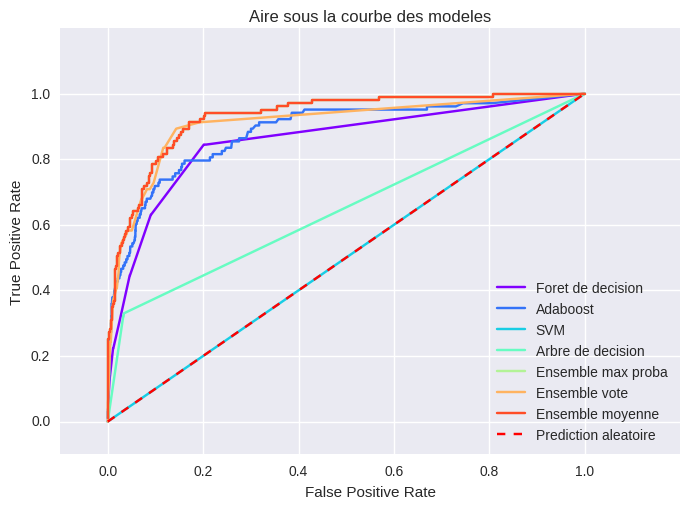

In [145]:
from copy import deepcopy
#affiche l'aire sous la courbe pour un random forest classifier
from sklearn.metrics import roc_curve, auc
import seaborn as sn
import matplotlib.pyplot as plt
predictions2 = deepcopy(predictions)
predictions2.append(prediction_soft)
predictions2.append(pred_hard)
predictions2.append(voting_mean)
colormap = plt.cm.rainbow
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(predictions2))])
models_names = ["Foret de decision","Adaboost","SVM","Arbre de decision","Ensemble max proba","Ensemble vote","Ensemble moyenne"]
for y_pred,name in zip(predictions2,models_names):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(ytrain, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print(roc_auc)
    plt.plot(false_positive_rate, true_positive_rate, 
    label=name )
plt.plot([0,1],[0,1],'r--',label="Prediction aleatoire")
plt.title('Aire sous la courbe des modeles')
plt.legend(loc='lower right')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [151]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]
    print(roc_t)

    return list(roc_t['threshold']) 
for y_pred,name in zip(predictions2,models_names):
    print(name)
    Find_Optimal_Cutoff(ytrain, y_pred)

Foret de decision
          tf  threshold
13  0.046149        0.1
Adaboost
           tf  threshold
120 -0.002395       0.18
SVM
    tf  threshold
0 -1.0        2.0
Arbre de decision
         tf  threshold
3 -0.635878       0.25
Ensemble max proba
          tf  threshold
98  0.000036   0.169251
Ensemble vote
          tf  threshold
31  0.036745        0.1
Ensemble moyenne
          tf  threshold
98  0.000036   0.169251


# Count errors :

In [188]:
seuils = [0.1,0.18,2.0,0.25,0.169251,0.1,0.16951]
pred_with_seuil = []
for p,seuil in zip(predictions2,seuils):
    pred_with_seuil.append([int(t>seuil) for t in p])
#number of errors (predict human but was robot) :
by_model_error_human_robot = {}
#number of errors (predict robot but was human) :
by_model_error_robot_human = {}
#number of errors : 
nb_errors = {}
for d,name in zip(pred_with_seuil,models_names):
    by_model_error_human_robot[name] = 0
    by_model_error_robot_human[name] = 0
    for pred,true_val  in zip(d,ytrain):
        if pred == 0 and true_val == 1.0:
            by_model_error_human_robot[name] +=1
        elif pred == 1.0 and true_val == 0:
            by_model_error_robot_human[name] += 1
    nb_errors[name] = np.sum((np.abs(d-ytrain)))
print(by_model_error_human_robot)
print(by_model_error_robot_human)
print(nb_errors)

{'SVM': 103, 'Ensemble moyenne': 15, 'Arbre de decision': 70, 'Ensemble max proba': 15, 'Ensemble vote': 17, 'Adaboost': 21, 'Foret de decision': 38}
{'SVM': 0, 'Ensemble moyenne': 270, 'Arbre de decision': 62, 'Ensemble max proba': 273, 'Ensemble vote': 224, 'Adaboost': 379, 'Foret de decision': 171}
{'SVM': 103, 'Ensemble moyenne': 285, 'Arbre de decision': 132, 'Ensemble max proba': 288, 'Ensemble vote': 241, 'Adaboost': 400, 'Foret de decision': 209}


# Feature selection 

In [20]:
from sklearn.feature_selection import RFECV
estimator = RandomForestClassifier(max_depth=8,random_state=9,criterion='entropy',n_estimators=250) 
selector = RFECV(estimator, step=1, cv=10,n_jobs=-1,scoring="roc_auc",verbose=2)
selector = selector.fit(train, ytrain)

Fitting estimator with 446 features.
Fitting estimator with 446 features.
Fitting estimator with 446 features.
Fitting estimator with 446 features.
Fitting estimator with 445 features.
Fitting estimator with 445 features.
Fitting estimator with 445 features.
Fitting estimator with 445 features.
Fitting estimator with 444 features.
Fitting estimator with 444 features.
Fitting estimator with 444 features.
Fitting estimator with 444 features.
Fitting estimator with 443 features.
Fitting estimator with 443 features.
Fitting estimator with 443 features.
Fitting estimator with 443 features.
Fitting estimator with 442 features.
Fitting estimator with 442 features.
Fitting estimator with 442 features.
Fitting estimator with 442 features.
Fitting estimator with 441 features.
Fitting estimator with 441 features.
Fitting estimator with 441 features.
Fitting estimator with 441 features.
Fitting estimator with 440 features.
Fitting estimator with 440 features.
Fitting estimator with 440 features.
F

In [14]:
from sklearn.externals import joblib

selector = joblib.load('feat_selector.pkl')
train2 = train.iloc[:, selector.get_support()]
#s = joblib.dump(selector,'feat_selector.pkl')
#test_models(train2,ytrain)
#print("----------------------------------------------------------")
#test_models(train,ytrain)

Feature ranking:


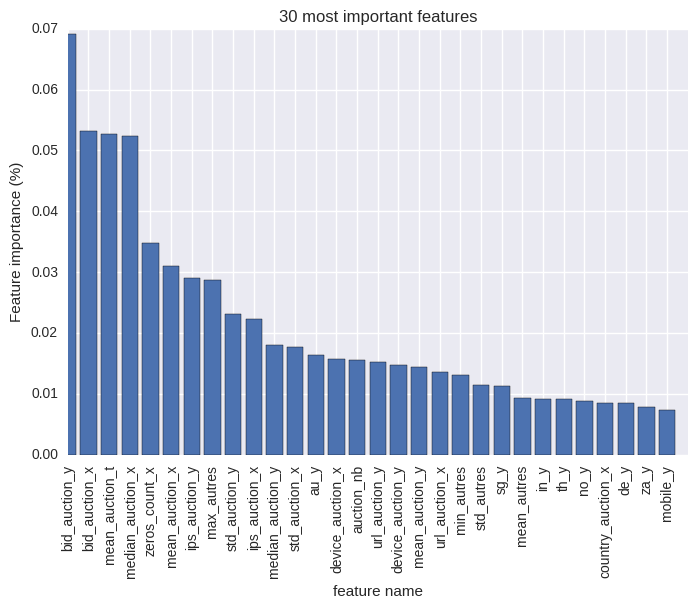

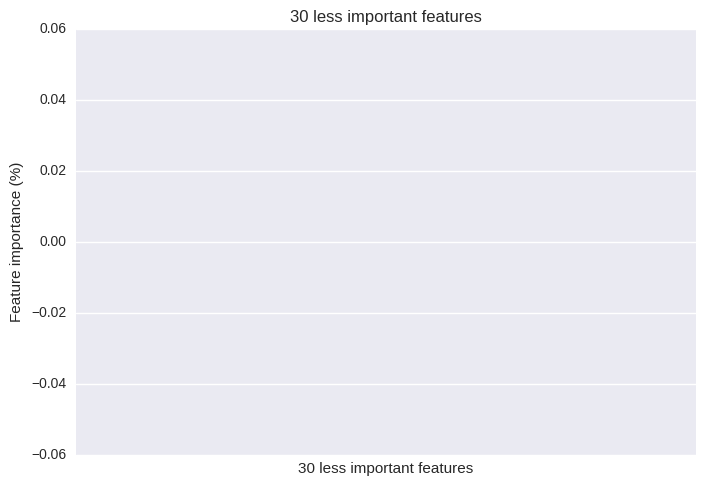

In [25]:
#affiche les 30 features les plus importantes et les 30 les moins importantes
import matplotlib.pyplot as plt
import seaborn as sn
clf = RandomForestClassifier(n_estimators=160,max_depth=8, max_features = 35 , random_state=9,criterion='entropy')
clf.fit(train, ytrain)
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

'''for f in range(train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
'''
# Plot the feature importances of the forest
plt.figure()
plt.title("30 most important features")
#N most important features
N  = 30
#N_1 less important features
N_1 = 30
plt.bar(range(train.shape[1])[:N], importances[indices][:N],
       align="center")
names = train.columns
plt.xticks(range(train.shape[1])[:N], [names[i] for i in indices[:N]],rotation=90)
plt.xlim([0, N])
plt.xlabel("feature name")
plt.ylabel("Feature importance (%)")
plt.show()
#les important features
plt.figure()
plt.title("30 less important features")
plt.bar(range(train.shape[1])[-N_1:], importances[indices][-N_1:],
       align="center")
plt.xticks(range(train.shape[1])[-N_1:], indices[-N_1:],rotation=90)
plt.xlim([0, N_1])
plt.xlabel("30 less important features")
plt.ylabel("Feature importance (%)")
plt.show()

In [4]:
#ancien code pour creer des features
from tools import *

def stats_country(sub_data,line):
    dicts = sub_data['merchandise'].value_counts()
    for typ, value in dicts.iteritems():
        line[typ] = value
    for c in sub_data['country'].unique():
        line[str(c)] = 1
def test_apply(data):
    line = {"test" : 5}
    return pd.Series(line)
def basic_stats(sub_data):
    t1 = sub_data.shape
    return t1[0]
def features_times(bids):
    #tmp_copye = bids.copy()
    #tmp_copye = tmp_copye[tmp_copye["bidder_id"]=="0051aef3fdeacdadba664b9b3b07e04e4coc6"]
    bidders = bids.groupby(['bidder_id', 'auction'])
    df = []
    for bid in bidders:
        sub_data = bid[1]
        time_moving = np.ediff1d(sub_data['time'])
        if len(time_moving)>0:
            min_v = np.min(time_moving)
            mean_v = np.mean(time_moving)
            std_v = np.std(time_moving)
            median_v = np.median(time_moving)
            zeros_count = len(time_moving) - np.count_nonzero(time_moving)
        else:
            min_v,mean_v,std_v,median_v,zeros_count = 0.0,0.0,0.0,0.0,0.0
        line = dict.fromkeys(categories, 0)
        line.update(dict.fromkeys(countries_list, 0))
        line["bidder_id"] = bid[0][0]
        line["auction"] = bid[0][1]
        #line["min_auction"] = min_v
        line["mean_auction"] = mean_v
        line["std_auction"] = std_v
        line["median_auction"] = median_v
        line["zeros_count"] = zeros_count
        #ips
        line['ips_auction'] = basic_stats(sub_data['ip'].unique())
        #urls
        line['url_auction'] = basic_stats(sub_data['url'].unique())
        #device
        line['device_auction'] = basic_stats(sub_data['device'].unique())
        #countries
        line['country_auction'] = basic_stats(sub_data['country'].unique())
        #bids
        line['bid_auction'] = sub_data.shape[0]
        #merchandises
        line['merchan_auction'] = basic_stats(sub_data['merchandise'].unique())
        stats_country(sub_data,line)
        df.append(line)
    pd.DataFrame(df).to_csv('res/stats_test.csv',index=False)
    
def features_times_simple(bids):
    bids = pd.read_csv('bids.csv')
    #tmp_bids = bids.copy()
    #tmp_bids = tmp_bids[tmp_bids["bidder_id"]=="fa64831ab5ade55daee13f852c16b0a84ujt0"]
    bidders = bids.groupby(['bidder_id'])
    df = []
    for bid in bidders:
        #print(np.mean(np.ediff1d((bid[1].time))))
        sub_data = bid[1]
        time_moving = np.ediff1d(sub_data['time'])
        if len(time_moving)>0:
            min_v = np.min(time_moving)
            mean_v = np.mean(time_moving)
            std_v = np.std(time_moving)
            median_v = np.median(time_moving)
            zeros_count = len(time_moving) - np.count_nonzero(time_moving)
        else:
            min_v,mean_v,std_v,median_v,zeros_count = 0.0,0.0,0.0,0.0,0.0
        line = dict.fromkeys(categories, 0)
        line.update(dict.fromkeys(countries_list, 0))
        line["bidder_id"] = bid[0]
        #line["min_auction"] = min_v
        line["mean_auction"] = mean_v
        line["std_auction"] = std_v
        line["median_auction"] = median_v
        line["zeros_count"] = zeros_count
        #ips
        line['ips_auction'] = basic_stats(sub_data['ip'].unique())
        #urls
        line['url_auction'] = basic_stats(sub_data['url'].unique())
        #device
        line['device_auction'] = basic_stats(sub_data['device'].unique())
        #countries
        line['auction_nb'] = sub_data['auction'].unique().shape[0]
        line['country_auction'] = basic_stats(sub_data['country'].unique())
        #bids
        line['bid_auction'] = sub_data.shape[0]
        #merchandises
        line['merchan_auction'] = basic_stats(sub_data['merchandise'].unique())
        stats_country(sub_data,line)
        line['mean_auction_t'] = np.mean(sub_data['auction'].value_counts())
        df.append(line)
    pd.DataFrame(df).to_csv('res/stats_test_simple.csv',index=False)

recreate= False
if recreate:
    features_times(bids)
recreate2 = True
if recreate2:
    features_times_simple(bids)

"
kf = StratifiedKFold(y=ytrain, n_folds=10)
scores = []
for train_index, test_index in kf:
    X_train, X_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = ytrain.iloc[train_index], ytrain.iloc[test_index]
    predictions = predict(X_train, X_test, y_train)
    scores.append(roc_auc_score(y_test, predictions))
print np.mean(scores)


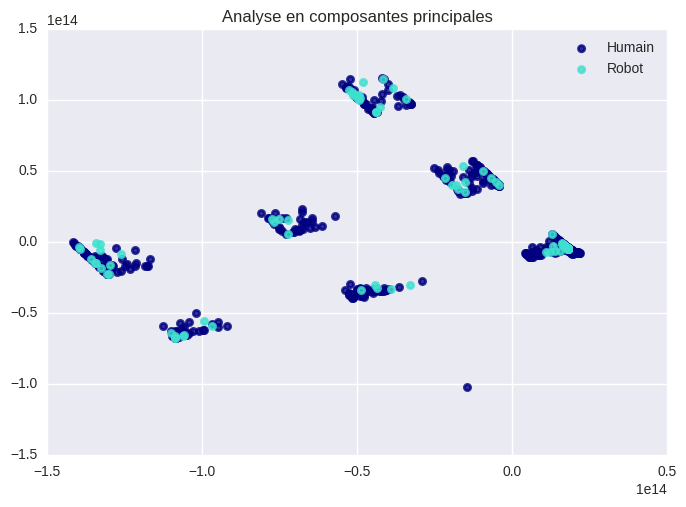

In [98]:
print(__doc__)

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA,KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


pca = KernelPCA(n_components=2,kernel='linear')
X = train
y = ytrain
X_r = pca.fit(X).transform(X)

plt.figure()
colors = ['navy', 'turquoise']
lw = 2

plt.scatter(X_r[y==0][:,0],X_r[y==0][:,1], color='navy', alpha=.8, lw=lw,label='Humain')
plt.scatter(X_r[y==1][:,0],X_r[y==1][:,1], color='turquoise', alpha=.8, lw=lw,label='Robot')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Analyse en composantes principales')

plt.show()

# Feature correlation

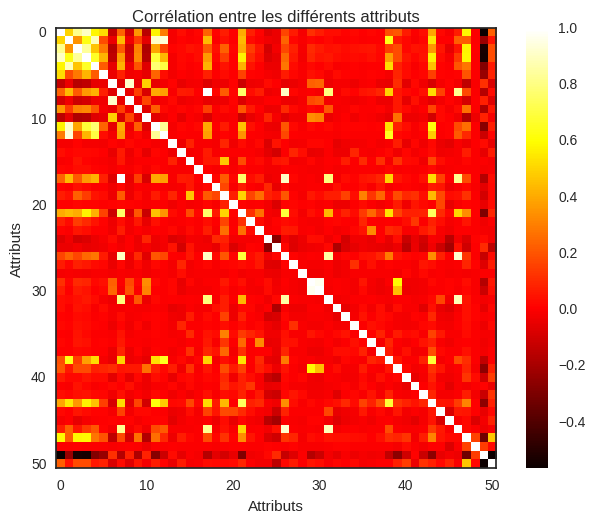

In [31]:
import matplotlib.pyplot as plt
import seaborn as sn
R = train2.corr()
#plt.figure(figsize=(13, 13))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
with sn.axes_style("white"):
    plt.imshow(R, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('Attributs')
plt.ylabel('Attributs')
plt.title("Corrélation entre les différents attributs")
plt.colorbar()
plt.show()

import sys
reload(sys)
sys.setdefaultencoding("utf-8")
('DecisionTree with features', [0, 1], 'has a score of', 0.99798387096774188)
('RandomForest with 30 estimators with features', [0, 1], 'has a score of', 0.99647177419354838)
('ExtraTrees with 30 estimators with features', [0, 1], 'has a score of', 0.99798387096774188)
('AdaBoost with 30 estimators with features', [0, 1], 'has a score of', 0.98639112903225812)
('DecisionTree with features', [0, 2], 'has a score of', 0.99798387096774188)
('RandomForest with 30 estimators with features', [0, 2], 'has a score of', 0.99697580645161288)
('ExtraTrees with 30 estimators with features', [0, 2], 'has a score of', 0.99798387096774188)
('AdaBoost with 30 estimators with features', [0, 2], 'has a score of', 0.98639112903225812)
('DecisionTree with features', [2, 3], 'has a score of', 0.99798387096774188)
('RandomForest with 30 estimators with features', [2, 3], 'has a score of', 0.99697580645161288)
('ExtraTrees with 30 estimators with feature

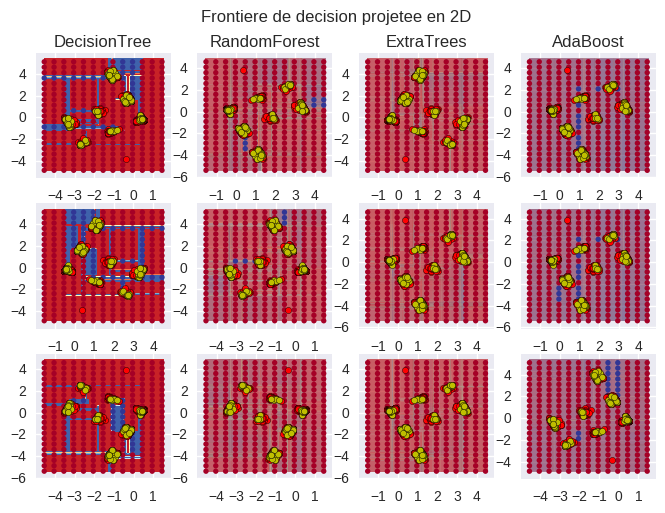

In [42]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn import clone
from sklearn.datasets import load_iris
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)
from sklearn.externals.six.moves import xrange
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import KernelPCA

# Parameters
n_classes = 3
n_estimators = 30
plot_colors = "ryb"
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration

# Load data
iris = load_iris()

plot_idx = 1

models = [DecisionTreeClassifier(max_depth=None),
          RandomForestClassifier(n_estimators=n_estimators),
          ExtraTreesClassifier(n_estimators=n_estimators),
          AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                             n_estimators=n_estimators)]

for pair in ([0, 1], [0, 2], [2, 3]):
    for model in models:
        
        X = KernelPCA(n_components=2).fit_transform(train)
        y = ytrain.values
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        # Train
        clf = clone(model)
        clf = model.fit(X, y)

        scores = clf.score(X, y)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = str(type(model)).split(".")[-1][:-2][:-len("Classifier")]
        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(len(model.estimators_))
        print( model_details + " with features", pair, "has a score of", scores )

        plt.subplot(3, 4, plot_idx)
        if plot_idx <= len(models):
            # Add a title at the top of each column
            plt.title(model_title)

        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a black outline
        xx_coarser, yy_coarser = np.meshgrid(np.arange(x_min, x_max, plot_step_coarser),
                                             np.arange(y_min, y_max, plot_step_coarser))
        Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(), yy_coarser.ravel()]).reshape(xx_coarser.shape)
        cs_points = plt.scatter(xx_coarser, yy_coarser, s=15, c=Z_points_coarser, cmap=cmap, edgecolors="none")

        # Plot the training points, these are clustered together and have a
        # black outline
        for i, c in zip(xrange(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=c, label=iris.target_names[i],
                        cmap=cmap)
        plot_idx += 1  # move on to the next plot in sequence

plt.suptitle("Frontiere de decision projetee en 2D")
plt.axis("tight")

plt.show()

import sys
reload(sys)
sys.setdefaultencoding("utf-8")
9


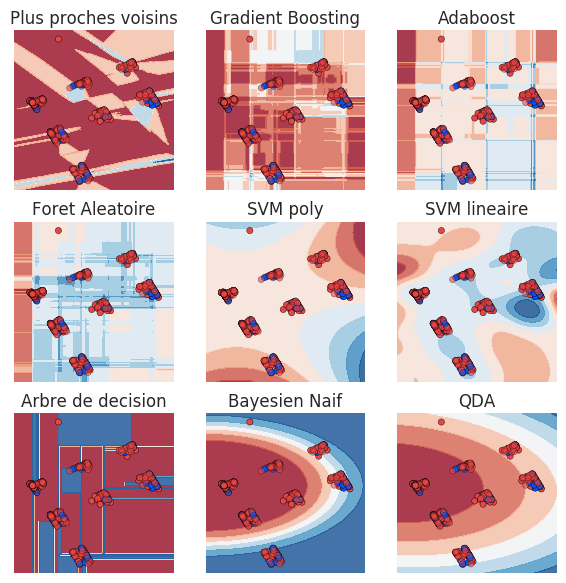

In [9]:
print(__doc__)


# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib.colors import ListedColormap
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Plus proches voisins", "Gradient Boosting", "Adaboost","Foret Aleatoire","SVM poly","SVM lineaire","Arbre de decision","Bayesien Naif","QDA"]

classifiers = [
    KNeighborsClassifier(3),
    RandomForestClassifier(n_estimators=160,max_depth=8,  random_state=9,criterion='entropy'),
    GradientBoostingClassifier(),AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=200,max_depth=8, random_state=9,criterion='entropy')),
    SVC(kernel="poly",probability=True),SVC(probability=True),DecisionTreeClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]
print(len(classifiers))
datasets = [""]
figure = plt.figure(figsize=(7, 7))
i = 1

X = KernelPCA(n_components=2).fit_transform(train)
y = ytrain.values
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.3, random_state=42)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#E84545', '#0155FE'])
ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
# and testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
# iterate over classifiers
for name, clf in zip(names, classifiers):
    ax = plt.subplot(3, 3, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Pt the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    plt.title(name)
    i += 1
#plt.title("Frontieres de decisions")
plt.show()